<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Приведение-к-стационарности" data-toc-modified-id="Приведение-к-стационарности-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Приведение к стационарности</a></span></li><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Создание признаков</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li><li><span><a href="#Дополнение.-Проверка-работы-моделей-с-полным-набором-недельных-признаков" data-toc-modified-id="Дополнение.-Проверка-работы-моделей-с-полным-набором-недельных-признаков-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Дополнение. Проверка работы моделей с полным набором недельных признаков</a></span></li></ul></div>

#  Прогнозирование заказов такси

**В данной работе необходимо построить модель машинного обучения, которая будет предсказывать количество заказов такси в аэропортах для каждого последующего часа**<br>
Для данного исследования мы будем использовать исторические данные о заказах такси в аэропортах от компании «Чётенькое такси». В ходе работы рассмотрим имеющиеся данные, при необходимости почистим их, приведем временной ряд к более-менее стационарному для последующей работы над ним. Далее на основании имеющихся данных создадим признаки для обучения моделей и возможности предсказаний. В конце проверим работу моделей на тестовых данных и выберем оптимальную модель.


## Подготовка

Загрузим данные и внимательно их изучим

In [ ]:
import pandas as pd

from copy import deepcopy
from pandas_profiling import ProfileReport

from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

rcParams["figure.figsize"] = 15, 8

from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from catboost import CatBoostRegressor

SEED = 777

In [ ]:
data = pd.read_csv("/datasets/taxi.csv", parse_dates=[0], index_col=[0])

In [4]:
ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Мы имеем небольшой датасет на 26.5 тыс. записей, здесь всего один столбец, показывающий количество заказов такси каждые 10 минут с марта 2018года по сентябрь того же года. Пропуски в данных отсутствуют. Указание на дубликаты, говорит только о том, что количество заказов может повторяться.

Так как нам необходимо предсказывать количество заказов на следующий час - пересемплируем датасет с группировкой количества заказов по часу

In [ ]:
data = data.sort_index()
data = data.resample("1H").sum()

## Анализ

### Приведение к стационарности

Для корректной работы моделей внимательно рассмотрим как меняются данные во времени, а также посмотрим на сезонную и трендовую составляющую имеющихся данных

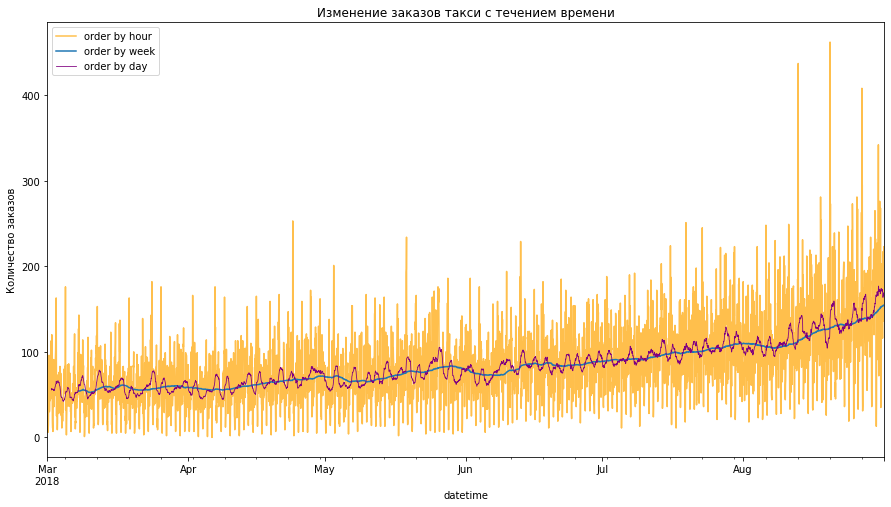

In [ ]:
ax = data.plot(
    title="Изменение заказов такси с течением времени",
    c="orange",
    ylabel="Количество заказов",
    alpha=0.7,
)
data.rolling(24 * 7).mean().plot(
    ax=ax,
)
data.rolling(24).mean().plot(ax=ax, c="purple", linewidth=0.8)
ax.legend(("order by hour", "order by week", "order by day"));

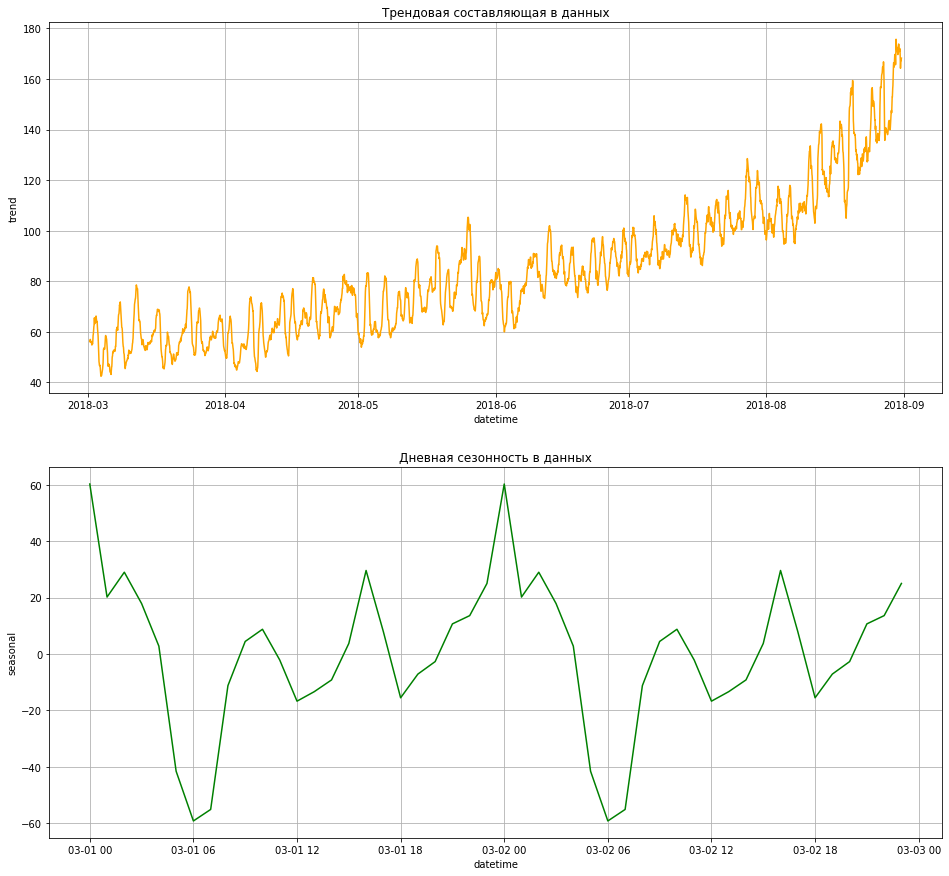

In [ ]:
decomposed = seasonal_decompose(data)

f, (ax1, ax2) = plt.subplots(2, 1, sharey=False, figsize=(16, 15))

sns.lineplot(data=decomposed.trend, ax=ax1, color="orange")
ax1.set_title("Трендовая составляющая в данных")
ax1.grid()


sns.lineplot(data=decomposed.seasonal["2018-03-01":"2018-03-02"], ax=ax2, color="green")
ax2.set_title("Дневная сезонность в данных")
ax2.grid();

По графикам видно наличие трендовой составляющей в наших данных - заметно, что с несмотря на колебания заказов такси со временем становится все больше - настолько, что к концу полугодия средние значения количества заказов увеличиваются в 2 раза. Также можно наблюдать сезонную составляющую на графике - здесь мы видим постоянное колебание количества заказов в течении суток с пиком заказов в полночь и упадком спроса в течении ночи с минимумом заказов в 6 утра каждого дня. 

Для полной картины взглянем также на сезонную составляющую заказов такси относительно дней в течении недели. 

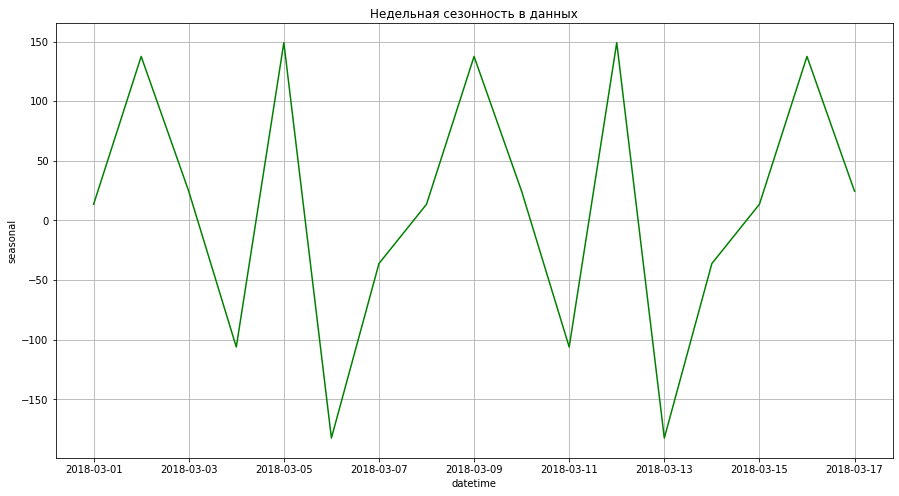

In [ ]:
decomposed_day = seasonal_decompose(data.resample("1D").sum())

ax = sns.lineplot(
    data=decomposed_day.seasonal["2018-03-01":"2018-03-17"], color="green"
)
ax.set_title("Недельная сезонность в данных")
ax.grid()

В дополнение к вышесказанному, мы можем наблюдать цикличность заказов такси в течении недели - причем при недельной цикличности мы имеем 2 выраженных пиковых дня разделенных 3мя сутками и один день недели имеющий сильный упадок в заказах.

**Таким образом мы увидели наличие постоянного тренда на увеличение количества заказов с течением времени. Также была найдена четкая сезонная составляющая в течении суток с пиковой загрузкой в полночь, и сезонная составляющая в течении недели со 2мя пиковыми днями и одним малорезультативным днем.**

### Создание признаков

Чтобы модели машинного обучения могли предсказывать заказы в будущем времени, создадим числовые признаки из нашего целевого признака `num_orders` с некоторым сдвигом данных.

Во-первых добавим 3 скользящие средние значения - для периода в 6 часов, в сутки и для недельного периода.

In [ ]:
data_shift = deepcopy(data)

for i in [6, 24, 24 * 7]:
    data_shift["roll_window_{}".format(i)] = (
        data_shift["num_orders"].shift().rolling(i).mean()
    )

Теперь добавим данные с лагом(отстающие) - данные за каждый из последних 4х часов, за 3 часа с предыдущих суток, и за три часа с такого же дня предыдущей недели.

In [ ]:
for lag in [1, 2, 3, 4, 23, 24, 25, 24 * 7 - 1, 24 * 7, 24 * 7 + 1]:
    data_shift["lag_{}".format(lag)] = data_shift["num_orders"].shift(lag)

Так как наши данные захватывают всего 8 месяцев года и не имеют годовую цикличность и повторяющиеся месяца, то добавим признак номера дня недели, также в связи с наличием суточной цикличности заказов добавим информацию о часе.

In [ ]:
data_shift["day_of_week"] = data_shift.index.day_of_week
data_shift["hour"] = data_shift.index.hour

Теперь удалим начальные строки с пропусками и на всякий случай проверим корреляцию между созданными признаками

In [13]:
data_shift = data_shift.dropna()

In [ ]:
data_shift.corr().style.background_gradient(cmap="Wistia")

,num_orders,roll_window_6,roll_window_24,roll_window_168,lag_1,lag_2,lag_3,lag_4,lag_23,lag_24,lag_25,lag_167,lag_168,lag_169,day_of_week,hour
num_orders,1.000000,0.475636,0.547850,0.554118,0.620200,0.457352,0.309507,0.237779,0.553265,0.688492,0.547065,0.588569,0.805516,0.591374,-0.020637,0.000896
roll_window_6,0.475636,1.000000,0.792455,0.760628,0.651060,0.741816,0.791989,0.791839,0.342217,0.410364,0.521226,0.350746,0.427238,0.566785,-0.040676,-0.160168
roll_window_24,0.547850,0.792455,1.000000,0.949842,0.569029,0.572726,0.576230,0.579432,0.568253,0.561949,0.538436,0.483435,0.486545,0.496076,-0.028546,0.006327
roll_window_168,0.554118,0.760628,0.949842,1.000000,0.555116,0.554347,0.553724,0.553238,0.552027,0.550635,0.549675,0.516654,0.515032,0.511981,-0.015308,0.006281
lag_1,0.620200,0.651060,0.569029,0.555116,1.000000,0.619424,0.456998,0.308980,0.397511,0.552339,0.687826,0.429473,0.587562,0.805324,-0.028504,-0.082139
lag_2,0.457352,0.741816,0.572726,0.554347,0.619424,1.000000,0.619101,0.456538,0.253857,0.395730,0.551201,0.277018,0.427716,0.586938,-0.031026,-0.123112
lag_3,0.309507,0.791989,0.576230,0.553724,0.456998,0.619101,1.000000,0.618908,0.207222,0.252968,0.395102,0.203234,0.276019,0.427377,-0.030423,-0.156876
lag_4,0.237779,0.791839,0.579432,0.553238,0.308980,0.456538,0.618908,1.000000,0.186500,0.206264,0.252160,0.179814,0.202155,0.275544,-0.029980,-0.145729
lag_23,0.553265,0.342217,0.568253,0.552027,0.397511,0.253857,0.207222,0.186500,1.000000,0.618034,0.452811,0.660422,0.524695,0.365178,0.018997,0.198276
lag_24,0.688492,0.410364,0.561949,0.550635,0.552339,0.395730,0.252968,0.206264,0.618034,1.000000,0.616680,0.521106,0.658826,0.524008,0.028567,0.001504


Корреляция в пределах нормы, можно приступать к обучению моделей.

## Обучение

Для начала разделим данные на обучающую и тестовую выборку, и выделим целевой признак из выборок

In [15]:
train, test = train_test_split(data_shift, shuffle=False, test_size=0.1)

In [ ]:
fea_train = train.drop("num_orders", axis=1)
fea_test = test.drop("num_orders", axis=1)
target_train = train["num_orders"]
target_test = test["num_orders"]

Так как мы имеем дело с числовыми непрерывными данными то в процессе обучения будем их масштабировать с помощью `StandardScaler`.

In [17]:
scaller = StandardScaler()

Теперь подготовим словари с моделями, параметрами для подбора через GridSearchCV, оценками и обученными моделями.<br>
Для сравнения будем использовать следующие модели:
- LinearRegression
- RandomForestRegressor
- CatBoostRegressor
- KNeighborsRegressor

In [ ]:
models = {
    "Lin_regression_model": LinearRegression(),
    "Forest_model": RandomForestRegressor(random_state=SEED),
    "CatBoost_model": CatBoostRegressor(
        random_state=SEED, learning_rate=0.16, min_data_in_leaf=70
    ),
    "Neighbors_model": KNeighborsRegressor(),
}

params = {
    "Lin_regression_model": {},
    "Forest_model": {
        "Forest_model__n_estimators": [50, 120],
        "Forest_model__max_depth": [6, 10],
    },
    "CatBoost_model": {
        "CatBoost_model__iterations": [80, 120],
        "CatBoost_model__depth": [4, 7],
    },
    "Neighbors_model": {
        "Neighbors_model__n_neighbors": [5, 7],
        "Neighbors_model__algorithm": ["ball_tree", "kd_tree"],
        "Neighbors_model__p": [1, 2],
    },
}

scores = {}
fit_models = {}

Переберем модели и их параметры, определим лучшую и все результаты запишем в отдельные словари.

In [ ]:
%%time
best_score = 1000

for key in models:
    cv = TimeSeriesSplit(n_splits=4).split(fea_train, target_train)
    my_pipe = Pipeline([("sc", scaller), (key, models[key])])
    grid = GridSearchCV(
        my_pipe,
        param_grid=params[key],
        cv=cv,
        scoring="neg_root_mean_squared_error",
        verbose=200,
        refit=True,
    )

    grid.fit(fea_train, target_train)
    scores[key] = [abs(grid.best_score_)]
    fit_models[key] = grid.best_estimator_

    if abs(grid.best_score_) < abs(best_score):
        best_model = grid.best_estimator_
        best_score = grid.best_score_

In [ ]:
print("Оценки моделей на обучающей выборке (rmse):")
scores

Оценки моделей на обучающей выборке (rmse):


{'Lin_regression_model': [23.452100891884243],
 'Forest_model': [23.60444485693674],
 'CatBoost_model': [23.517455534861007],
 'Neighbors_model': [25.39027666996151]}

В результате лучшую оценку rmse на тренировочной выборке показала модель простой линейной регресии LineanRegression - 23.26. Следующей моделью по успешной оценки является  CatBoostRegressor

## Тестирование

Теперь необходимо посмотреть какие оценки покажут модели на тестовой выборке. Чтобы оценить степень переобучения посмотрим какие оценки покажут все модели.

In [ ]:
for key in fit_models:
    prediction = fit_models[key].predict(fea_test)
    scores[key].append(root_mean_squared_error(target_test, prediction, squared=False))

print("Оценки моделей на обучающей и тестовой выборке (rmse):")
scores

Оценки моделей на обучающей и тестовой выборке (rmse):


{'Lin_regression_model': [23.452100891884243, 35.26181026664096],
 'Forest_model': [23.60444485693674, 42.59573990170924],
 'CatBoost_model': [23.517455534861007, 40.752965883537094],
 'Neighbors_model': [25.39027666996151, 44.20680364599366]}

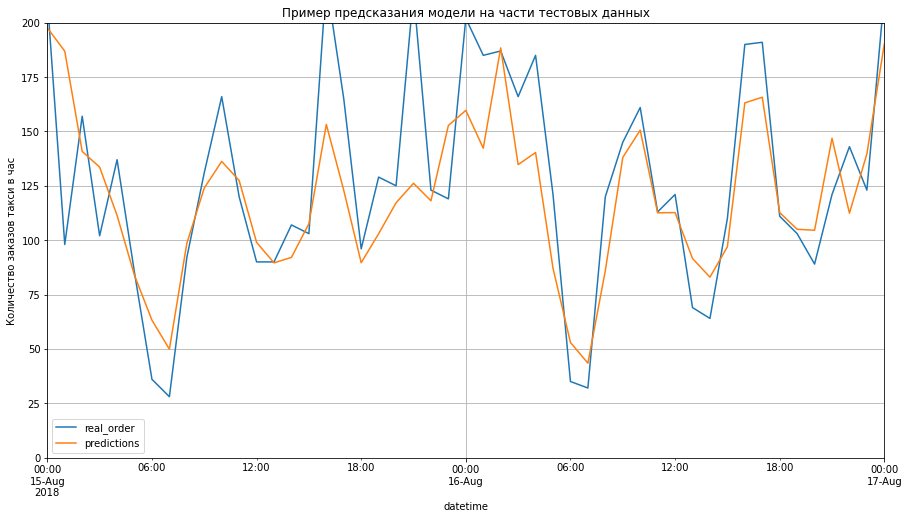

In [ ]:
best_predict = best_model.predict(fea_test)
best_predict = pd.Series(data=best_predict, index=fea_test.index)
ax = target_test.plot(grid=True)
ax.set_title("Пример предсказания модели на части тестовых данных")
best_predict.plot(xlim=("2018-08-15", "2018-08-17"), ylim=(0, 300), grid=True)
ax.set_ylabel("Количество заказов такси в час")
ax.legend(("real_order", "predictions"));

**В итоге мы получили лучшие оценки на тестовой и обучающей выборке у модели линейной регрессии с отрывом примерно на 12% от остальных моделей**

_Вывод: По ходу данной работы мы исследовали данные компании «Чётенькое такси» о заказах такси в аэропортах. Изучили данные и добавили им дополнительные признаки для корректной работы моделей машинного обучения. Далее обучили, подобрали параметры и сравнили результаты предсказаний 4х моделей. Таким образом была выбрана модель Линейной регрессии с наименьшим отклонением в своих предсказаниях.

## Дополнение. Проверка работы моделей с полным набором недельных признаков

Сравним насколько дольше и эффективнее будет строиться таже работа моделей, если мы включим в наши данные все 168 прошлых заказов (весь недельный цикл). Далее мы добавим признаки, разделим данные, выделим целевые признаки, обучим модели, выберем лучшую и протестируем.

In [ ]:
data_full = deepcopy(data)

for i in [6, 24, 24 * 7]:
    data_full["roll_window_{}".format(i)] = (
        data_full["num_orders"].shift().rolling(i).mean()
    )

for lag in range(1, 169):
    data_full["lag_{}".format(lag)] = data_full["num_orders"].shift(lag)

data_full["day_of_week"] = data_full.index.day_of_week
data_full["hour"] = data_full.index.hour

data_full = data_full.dropna()

In [ ]:
train_full, test_full = train_test_split(data_full, shuffle=False, test_size=0.1)

fea_train_full = train_full.drop("num_orders", axis=1)
fea_test_full = test_full.drop("num_orders", axis=1)
target_train_full = train_full["num_orders"]
target_test_full = test_full["num_orders"]

models_full = {
    "Lin_regression_model": LinearRegression(),
    "Forest_model": RandomForestRegressor(random_state=SEED),
    "CatBoost_model": CatBoostRegressor(
        random_state=SEED, learning_rate=0.16, min_data_in_leaf=70
    ),
    "Neighbors_model": KNeighborsRegressor(),
}

params_full = {
    "Lin_regression_model": {},
    "Forest_model": {
        "Forest_model__n_estimators": [50, 120],
        "Forest_model__max_depth": [6, 10],
    },
    "CatBoost_model": {
        "CatBoost_model__iterations": [80, 120],
        "CatBoost_model__depth": [4, 7],
    },
    "Neighbors_model": {
        "Neighbors_model__n_neighbors": [5, 7],
        "Neighbors_model__algorithm": ["ball_tree", "kd_tree"],
        "Neighbors_model__p": [1, 2],
    },
}

scores_full = {}
fit_models_full = {}

In [ ]:
%%time
best_score = 1000

for key in models_full:
    cv = TimeSeriesSplit(n_splits=4).split(fea_train_full, target_train_full)
    my_pipe = Pipeline([("sc", scaller), (key, models_full[key])])
    grid = GridSearchCV(
        my_pipe,
        param_grid=params_full[key],
        cv=cv,
        scoring="neg_root_mean_squared_error",
        verbose=200,
        refit=True,
    )

    grid.fit(fea_train_full, target_train_full)
    scores_full[key] = [abs(grid.best_score_)]
    fit_models_full[key] = grid.best_estimator_

    if abs(grid.best_score_) < abs(best_score):
        best_model_full = grid.best_estimator_
        best_score_full = grid.best_score_

In [ ]:
print("Оценки моделей на обучающей выборке (rmse):")
scores_full

Оценки моделей на обучающей выборке (rmse):


{'Lin_regression_model': [22.874716705270412],
 'Forest_model': [23.15006447619824],
 'CatBoost_model': [22.972132548479042],
 'Neighbors_model': [26.221673148673553]}

In [ ]:
for key in fit_models_full:
    prediction = fit_models_full[key].predict(fea_test_full)
    scores_full[key].append(
        root_mean_squared_error(target_test_full, prediction, squared=False)
    )

print("Оценки моделей на обучающей и тестовой выборке (rmse):")
scores_full

Оценки моделей на обучающей и тестовой выборке (rmse):


{'Lin_regression_model': [22.874716705270412, 34.2357333994703],
 'Forest_model': [23.15006447619824, 39.01795405475221],
 'CatBoost_model': [22.972132548479042, 36.98935593517775],
 'Neighbors_model': [26.221673148673553, 48.76008000568564]}

_По итогам дополнительной проверки мы увидели, что все модели показали лучшие оценки и на тренировочной выборке, и на тестовой, кроме модели KNeighborsRegressor, которая на тестовых данных совсем "уехала". Лучшей моделью по-прежнему осталась модель Линейной Регресии которая улучшила свои метрики примерно на 3%. При этом видно, что модель CatBoostRegressor снизила степень своего переобучения. Паралельно с улучшением метрик мы конечно видим и увеличение времени на подбор лучшей модели и ее параметров, однако если бы для нас было важно только время обучения и время тестирвания лучшей модели, то такой способ получения дополнительных признаков имел бы хорошее преимущество._